In [1]:
%pylab inline
import pandas as pd
import time
#import numpy as np
import pickle
import joblib
from joblib import Parallel, delayed
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
from sklearn import linear_model as lm
import math as math
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.style.use('seaborn-white')
pandas.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


Static variables: 
subj_ethnicity, gender, age, diagnosis, Admission Weight (Kg)

Dynamic variables: 
['Heart Rate', 'Respiratory Rate','O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure mean', 
    'O2 Flow', 'Inspired O2 Fraction', 'Arterial CO2 Pressure', 'PH (Arterial)', 'Arterial O2 pressure', 
    'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
    'Tidal Volume (observed)', 'PEEP set', 'Creatinine', 'Hematocrit (serum)', 'BUN']
#'[Temperature Celsius]', '[Arterial O2 Saturation]', '[Richmond-RAS Scale]']

In [2]:
vitals_list = ['Heart Rate', 'Respiratory Rate','O2 saturation pulseoxymetry', 'Non Invasive Blood Pressure mean', 
               'O2 Flow', 'Inspired O2 Fraction', 'Arterial CO2 Pressure', 'PH (Arterial)', 'Arterial O2 pressure', 
               'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
               'Tidal Volume (observed)', 'PEEP set', 'Creatinine', 'Hematocrit (serum)', 'BUN', 
               'Admission Weight (Kg)']

inputs_list = ['Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Dexmedetomidine (Precedex)', 
               'Morphine Sulfate','Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)']
sbt_list = ['SBT Started', 'SBT Stopped', 'SBT Successfully Completed', 'SBT Deferred']

In [ ]:
allvitals_sorted = allvitals.sort_values(by=['subject', 'charttime'])
allvitals_sorted.to_pickle("allvitals.pkl")
asd = allvitals_sorted[allvitals_sorted.h_exp == 0]
allvitalsdc_sorted = allvitals_sorted[allvitals_sorted.h_exp == 0]
asd.to_pickle("allvitals_discharged.pkl")
(allvitalsdc_sorted[allvitalsdc_sorted.h_exp == 0].hadm.unique())

In [3]:
with open("pickles/allvitals_discharged.pkl",'rb') as f: allvitals_discharged = pickle.load(f)
with open("pickles/inputs_discharged.pkl",'rb') as f: inputs_discharged = pickle.load(f)
with open("pickles/vent_discharged.pkl",'rb') as f: vent_discharged = pickle.load(f)
with open("pickles/sbt_discharged.pkl",'rb') as f: sbt_discharged = pickle.load(f)

In [7]:
ventilation = vent_discharged
inputs = inputs_discharged
allvitals = allvitals_discharged

In [ ]:
for v in allvitlabels:
    print v, len(allvitalsdc[allvitalsdc.label==v].hadm), len(allvitalsdc[allvitalsdc.label==v].hadm.unique())

In [ ]:
vent_discharged = ventilation.loc[ventilation.h_exp == 0]
hadm_discharged = vent_discharged.hadm.unique()
allvit_discharged = allvitals.loc[allvitals.hadm.isin(hadm_discharged)]
allvitlabels = allvitalsdc_sorted.label.unique()

In [185]:
#h = 6
#ventilation[ventilation.hadm == hadms[h]].vent_endtime - ventilation[ventilation.hadm == hadms[h]].vent_starttime
#((ventilation.vent_endtime - ventilation.vent_starttime).astype('timedelta64[s]')/3600/24).sort_values(ascending=False)
hadms=ventilation.hadm.unique()
tooShort = (ventilation[(ventilation.vent_endtime - ventilation.vent_starttime).astype('timedelta64[s]')/3600/24 < 1]).hadm.unique()
tooLong = (ventilation[(ventilation.vent_endtime - ventilation.vent_starttime).astype('timedelta64[s]')/3600/24 > 32]).hadm.unique()
#justRight  = [val for val not in tooShort if val not in tooLong]
justRight = ([val for val in hadms if val not in tooShort if val not in tooLong])
pickle.dump(justRight, open( "ventd1to32hadms2.pkl", "wb" ) ) #len(justRight) = 3020

10   6 days 07:02:00
11   1 days 23:59:00
12   6 days 07:02:00
13   0 days 00:10:00
dtype: timedelta64[ns]

In [16]:
vent_filtered = ventilation[(ventilation.hadm.isin(justRight))]

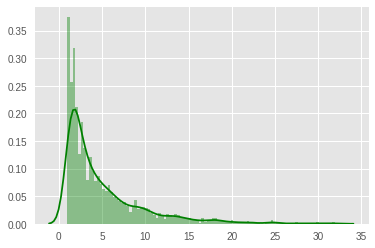

In [17]:
sns.distplot((vent_filtered.vent_endtime - vent_filtered.vent_starttime).astype('timedelta64[s]')/3600/24, 100, color='g')

In [80]:
vitd_lenfiltered = allvitals_discharged[allvitals_discharged.label.isin(vitals_list)]
vit_filtered = allvitals[allvitals.hadm.isin(justRight)]
inputs_filtered = inputs[inputs.hadm.isin(justRight)]
inputs_filtered = inputs_filtered[inputs_filtered.label.isin(inputs_list)]
vit_filtered = vit_filtered[vit_filtered.label.isin(vitals_list)]
sbt_filtered= sbt_discharged[sbt_discharged.hadm.isin(justRight)]

In [303]:
vent_filtered.to_pickle("ventd_lenfiltered.pkl")
inputs_filtered.to_pickle("inputsd_lenfiltered.pkl")
vit_filtered.to_pickle("vitd_lenfiltered.pkl")
sbt_filtered.to_pickle("sbtd_lenfiltered.pkl")

In [365]:
def buildTimeFrame(start, end, delta):
    times = []
    curr = start
    while curr < end:
        times.append(curr)
        curr += delta
    timeFrame = DataFrame(data={'timestamp': times}, index=times)
    return timeFrame
        
def getChartFrame(h, ventTable, sedTable, vitTable, sbtTable, vitalsList, sedationList, sbtList):    

    ### TIMEFRAME ###
    admitTime =  pd.to_datetime(ventTable[ventTable.hadm == h].admit_time.unique().item())
    admitTime -= dt.timedelta(minutes=admitTime.minute, seconds=admitTime.second, microseconds=admitTime.microsecond)
    dischTime = pd.to_datetime(ventTable[ventTable.hadm == h].discharge_time.unique().item())
    dischTime -= dt.timedelta(minutes=dischTime.minute, seconds=dischTime.second, microseconds=dischTime.microsecond)
    dischTime += dt.timedelta(hours = 1)
    chartFrame =  buildTimeFrame(admitTime, dischTime, timedelta(hours=1))
    
    ### IDENTIFIERS ###
    chartFrame['hadm'] = h
    chartFrame['subject'] = ventTable[ventTable.hadm == h].subject.head(1).item()
    
    #### STATIC VARIABLES ####
    chartFrame['icudays'] = (dischTime - admitTime).days 
    chartFrame['admittype'] = int(ventTable[ventTable.hadm == h].admittype.head(1).str.contains('EMERGENCY').item())   
    chartFrame['ethnicity'] = int(ventTable[ventTable.hadm == h].subj_ethnicity.head(1).str.contains('WHITE').item())
    chartFrame['gender'] = int(ventTable[ventTable.hadm == h].gender.head(1).str.contains('F').item())
    chartFrame['age'] = (ventTable[ventTable.hadm == h].admit_time.head(1).dt.year - 
                       ventTable[ventTable.hadm == h].dateofbirth.head(1).dt.year).item() % 210 # for censored >90s
    chartFrame['weight'] = vitTable[(vitTable.hadm == h) & 
                                    (vitTable.label == 'Admission Weight (Kg)')].head(1).value.item()
    
    ### VENT STATUS ###
    chartFrame['ventilated'] = 0
    for i,row in ventTable[ventTable.hadm == h].iterrows():
        ventStart = pd.to_datetime(row.vent_starttime)
        ventStart -= dt.timedelta(minutes=ventStart.minute, seconds=ventStart.second, microseconds=ventStart.microsecond)
        ventStart += dt.timedelta(hours = 1)
        ventEnd = pd.to_datetime(row.vent_endtime)
        ventEnd -= dt.timedelta(minutes=ventEnd.minute, seconds=ventEnd.second, microseconds=ventEnd.microsecond)
        for t in chartFrame.timestamp:
            if (pd.to_datetime(t) >= ventStart) and (pd.to_datetime(t) <= ventEnd): 
                chartFrame.loc[chartFrame.timestamp == t,'ventilated'] = 1

    ### SBT TIMES ###
    chartFrame['sbt'] = np.nan
    if len(sbtTable[(sbtTable.hadm == h)]) != 0:
        for v in sbtList:
            sbt_t = sbtTable[(sbtTable.hadm == h) & (sbtTable.label == v)].sort_values(by='charttime')
            sbt_t.set_index('charttime',inplace=True,drop=False)
            sbt_t = sbt_t.resample('1h').mean()
            sbt_t = sbt_t[sbt_t['subject'].notnull()]
            sbt_t['timestamp'] = sbt_t.index
            for t in chartFrame.timestamp:
                if sbt_t[sbt_t.timestamp == t].empty == False:
                    chartFrame.loc[chartFrame.timestamp == t,'sbt'] = v # overwrites if multiple things happen
                        
    ### DYNAMIC VARIABLES ###
    for v in vitalsList[:18]:
        chartFrame[v] = np.nan
        vitals_v = vitTable[(vitTable.hadm == h) & (vitTable.label == v)].sort_values(by='charttime')
        vitals_v.set_index('charttime',inplace=True,drop=False)
        vitals_v = vitals_v.resample('1h').mean().fillna(method="ffill")    
        vitals_v['timestamp'] = vitals_v.index
        for t in chartFrame.timestamp:
            if vitals_v[vitals_v.timestamp == t].empty == False:
                chartFrame.loc[chartFrame.timestamp == t,v] = vitals_v[vitals_v.timestamp == t].value.item()

    ### SEDATIVES ###    
    sedValue = {}
    for s in sedationList:
        chartFrame[s] = 0
        for t in chartFrame.timestamp: sedValue[s,t] = 0
        for i,row in sedTable[(sedTable.hadm==h) & (sedTable.label==s)].iterrows():
            if not row.empty:
                sedStart = pd.to_datetime(row.input_start)
                sedEnd = pd.to_datetime(row.input_end)
                sedDur = (sedEnd - sedStart).seconds/3600.0
                nextTS = pd.to_datetime(t) + dt.timedelta(hours = 1)
                #print pd.to_datetime(t), sedStart, sedEnd
                for t in chartFrame.timestamp:  
                    
                    if (pd.to_datetime(t) <= sedStart) and (pd.to_datetime(t) <= sedEnd): 
                        if (pd.to_datetime(t) + dt.timedelta(hours = 1) > sedStart): #sed starts, finishes after t, before t+1
                            if row.ordercat == 'Continuous Med': 
                                if (sedEnd < nextTS):
                                    sedValue[s,t] += float(row.amount)/sedDur
                                else: 
                                    sedValue[s,t] += float(row.amount)/sedDur*((nextTS - sedStart).seconds/3600.0) 
                        elif row.ordercat == 'Drug Push':
                            sedValue[s,t] += float(row.amount)
                            
                    if (pd.to_datetime(t) >= sedStart) and (pd.to_datetime(t) <= sedEnd): #sed starts before, finishes after t
                        if row.ordercat == 'Continuous Med': 
                            if (pd.to_datetime(t) + dt.timedelta(hours = 1) > sedEnd):
                                sedValue[s,t] += float(row.amount)/sedDur*((sedEnd - pd.to_datetime(t)).seconds/3600.0) 
                            else: 
                                sedValue[s,t] += float(row.amount)/sedDur*((nextTS - pd.to_datetime(t)).seconds/3600.0) 
                        
                    chartFrame.loc[chartFrame.timestamp == t,s] = int(round(sedValue[s,t]))
                        
        
    tmp = chartFrame[chartFrame['Ventilator Mode'].notnull()].head(4)
    chartFrame = tmp.append(chartFrame.loc[chartFrame.loc[chartFrame['Ventilator Mode'].notnull()].index 
                                           + timedelta(hours=4)])
    return chartFrame 


def produceFrames(output, h):
    output[h] = getChartFrame(h, vent_discharged, sed_discharged, vit_discharged, sbt_discharged,
                                       vitals_list, sedation_list, sbt_list)
    return output[h]

In [366]:
getChartFrame(165660, vent_filtered, inputs_filtered, vit_filtered, sbt_filtered, vitals_list, inputs_list, sbt_list)

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan)
2134-05-12 16:00:00,2134-05-12 16:00:00,165660,36,10,0,1,0,73,106.2,0,NaN,91.0,92.0,85.0,15.0,100.0,75.0,7.22,70.0,10.0,49.0,24.0,16.0,11.00,534.0,5.0,0.9,36.3,19.0,2,64,0,975,0,2,0,0
2134-05-12 17:00:00,2134-05-12 17:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,90.0,96.0,64.0,15.0,60.0,75.0,7.22,70.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,60,0,975,0,2,0,0
2134-05-12 18:00:00,2134-05-12 18:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,85.0,92.0,64.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,58,0,975,0,2,0,0
2134-05-12 19:00:00,2134-05-12 19:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,80.0,95.0,69.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,56,0,975,0,2,0,0
2134-05-12 20:00:00,2134-05-12 20:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,78.0,95.0,59.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,52,0,925,0,2,0,0
2134-05-12 21:00:00,2134-05-12 21:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,77.0,97.0,63.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,0.9,36.5,19.0,2,50,0,925,0,2,0,0
2134-05-12 22:00:00,2134-05-12 22:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,74.0,96.0,61.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,0,18,0,875,0,2,0,0
2134-05-12 23:00:00,2134-05-12 23:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,74.0,96.0,65.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,2,59,0,875,0,2,0,0
2134-05-13 00:00:00,2134-05-13 00:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,73.0,97.0,70.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,2,56,0,825,0,2,0,0
2134-05-13 01:00:00,2134-05-13 01:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,75.0,96.0,63.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,23.0,16.0,9.40,527.0,8.0,1.0,32.7,20.0,2,53,0,825,0,2,0,0


------------------------------------

In [25]:
with open("filteredFramesNew2.pkl",'rb') as f: filteredFramesNew = pickle.load(f)

In [20]:
filteredFramesNew[hadms[0]]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan)
2134-05-12 16:00:00,2134-05-12 16:00:00,165660,36,10,0,1,0,73,106.2,0,NaN,91.0,20.0,92.0,85.0,15.0,100.0,75.0,7.22,70.0,10.0,49.0,24.0,16.0,11.00,534.0,5.0,0.9,36.3,19.0,2,64,0,975,0,2,0,0
2134-05-12 17:00:00,2134-05-12 17:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,90.0,20.0,96.0,64.0,15.0,60.0,75.0,7.22,70.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,60,0,975,0,2,0,0
2134-05-12 18:00:00,2134-05-12 18:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,85.0,20.0,92.0,64.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,58,0,975,0,2,0,0
2134-05-12 19:00:00,2134-05-12 19:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,80.0,23.0,95.0,69.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,56,0,975,0,2,0,0
2134-05-12 20:00:00,2134-05-12 20:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,78.0,19.0,95.0,59.0,15.0,60.0,50.0,7.36,84.0,10.0,49.0,24.0,16.0,11.00,534.0,8.0,0.9,36.5,19.0,2,52,0,925,0,2,0,0
2134-05-12 21:00:00,2134-05-12 21:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,77.0,17.0,97.0,63.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,0.9,36.5,19.0,2,50,0,925,0,2,0,0
2134-05-12 22:00:00,2134-05-12 22:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,74.0,18.0,96.0,61.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,0,18,0,875,0,2,0,0
2134-05-12 23:00:00,2134-05-12 23:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,74.0,18.0,96.0,65.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,2,59,0,875,0,2,0,0
2134-05-13 00:00:00,2134-05-13 00:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,73.0,16.0,97.0,70.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,22.0,16.0,9.50,549.0,8.0,1.0,32.7,20.0,2,56,0,825,0,2,0,0
2134-05-13 01:00:00,2134-05-13 01:00:00,165660,36,10,0,1,0,73,106.2,1,NaN,75.0,15.0,96.0,63.0,15.0,60.0,50.0,7.36,84.0,12.0,49.0,23.0,16.0,9.40,527.0,8.0,1.0,32.7,20.0,2,53,0,825,0,2,0,0


In [11]:
for h in filteredFramesNew.keys():
    print h, len(filteredFramesNew[h]), filteredFramesNew[h].ventilated.tail(1).item()

139265 180 0
106507 188 0
188432 95 0
139284 199 1
113326 937 0
179708 87 0
180262 371 0
147496 113 0
114737 231 0
172082 230 1
170675 146 0
114740 31 0
163893 30 0
114743 34 0
163899 114 0
180285 43 0
106561 148 0
196674 103 0
188492 70 0
131151 109 0
122960 67 0
131162 184 1
172124 497 1
196702 41 1
196705 142 1
122980 169 0
172133 29 0
113481.0 219 nan
163951 105 1
131184 68 0
147569 262 0
139380 127 0
113343 47 1
196735 77 0
155780 255 1
196741 67 1
139400 277 1
147593 330 0
188554 88 0
100934 50 0
106638 47 0
111981 25 1
188571 62 1
139427 238 0
147620 48 0
188583 72 1
106665 64 0
196779 176 0
196782 176 1
114866 29 0
172216 149 0
114877.0 471 nan
131262 48 0
123073 71 0
180419 33 0
114884 85 0
164037 84 0
196809 81 1
188623 60 0
114902 374 1
164055 328 0
131289 30 0
114906 26 1
180446 29 0
170704 180 1
110630 173 0
123110 71 1
146129 240 0
164074 81 0
155885 31 0
164079 71 0
147696 46 0
196851 235 1
196852 127 1
155894 165 1
147703 475 1
139512 43 0
114939 78 1
131324 90 0
147709

In [26]:
extffn = {}
for h in filteredFramesNew.keys(): 
    if (filteredFramesNew[h].ventilated.tail(1).item() == 0):
        extffn[h] = filteredFramesNew[h]
        
maxv={}; minv={}; meanv = {}
for v in vitals_list[:19]:
    all = np.concatenate([extffn[h][v] for h in extffn.keys()])
    print v, (nanmean(all)), nanmedian(all), (nanmean(all)-10*nanstd(all)), (nanmean(all)+10*nanstd(all))
    maxv[v] = (nanmean(all)+10*nanstd(all))
    minv[v] = (nanmean(all)-10*nanstd(all))
    meanv[v] = (nanmean(all))

for h in extffn.keys():
    for v in vitals_list[:19]:
        extffn[h].ix[extffn[h][v] > maxv[v], v] = float('NaN')
        extffn[h].ix[extffn[h][v] < minv[v], v] = float('NaN')
    
maxv={}; minv={}; meanv = {}
for v in vitals_list[:19]:
    all = np.concatenate([extffn[h][v] for h in extffn.keys()])
    print v, (nanmean(all)), nanmedian(all), (nanmean(all)-3*nanstd(all)), (nanmean(all)+3*nanstd(all))
    maxv[v] = (nanmean(all)+3*nanstd(all))
    minv[v] = (nanmean(all)-3*nanstd(all))
    meanv[v] = (nanmean(all))

for h in extffn.keys():
    for v in vitals_list[:19]:
        extffn[h].ix[extffn[h][v] > maxv[v], v] = float('NaN')
        extffn[h].ix[extffn[h][v] < minv[v], v] = float('NaN')
        
def cleanup(frame):
    frame.dropna(subset=["timestamp"], inplace=True)
    frame.sbt.fillna(value='unknown', inplace=True)
    frame.fillna(method="ffill",inplace=True)
    frame.fillna(method="bfill",inplace=True) 
    for v in vitals_list[:19]:
        frame[v].fillna(value=meanv[v], inplace=True)
    return frame

for h in extffn.keys():
    cleanup(extffn[h])

Heart Rate 87.7757215882 87.0 -131.218141956 306.769585133
Respiratory Rate 24.2642089601 19.0 -22842.1612747 22890.6896926
O2 saturation pulseoxymetry 97.5788476571 98.0 54.1472028932 141.010492421
Non Invasive Blood Pressure mean 74.465366603 72.0 -154.396189205 303.326922411
O2 Flow 9.24128353314 10.0 -84.7841444502 103.266711517
Inspired O2 Fraction 47.0071750498 40.0 -300.372611596 394.386961695
Arterial CO2 Pressure 41.9989369797 41.0 -51.5151066998 135.512980659
PH (Arterial) 7.40765077665 7.41 6.61708291365 8.19821863966
Arterial O2 pressure 123.364827828 111.0 -420.104872023 666.834527679
Mean Airway Pressure 10.089564594 9.0 -33.6927603438 53.8718895319
Ventilator Mode 26.1388592551 11.0 -168.524757261 220.802475771
Peak Insp. Pressure 19.5336641734 19.0 -61.1942276418 100.261555989
Plateau Pressure 20.1843722243 20.0 -36.3112235021 76.6799679507
Minute Volume 9.64852841902 9.2 -61.0545470059 80.351603844
Tidal Volume (observed) 500.788433019 487.0 -30368.9013778 31370.478243

In [31]:
extffn[(extffn.keys()[0])]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan)
2169-01-26 08:00:00,2169-01-26 08:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,76.000000,17.000000,100.0,66.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12
2169-01-26 09:00:00,2169-01-26 09:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,104.500000,21.500000,99.5,80.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12
2169-01-26 10:00:00,2169-01-26 10:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,90.333333,16.333333,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,1077,3275,0,0,0,12
2169-01-26 11:00:00,2169-01-26 11:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,22.000000,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1261,3275,0,0,0,12
2169-01-26 12:00:00,2169-01-26 12:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,88.000000,17.000000,100.0,81.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,560,3275,0,0,0,12
2169-01-26 13:00:00,2169-01-26 13:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,102.000000,16.000000,99.0,65.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,763,3250,0,0,0,12
2169-01-26 14:00:00,2169-01-26 14:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,112.000000,16.000000,99.0,74.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1127,3125,0,0,0,12
2169-01-26 15:00:00,2169-01-26 15:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,98.000000,16.000000,100.0,86.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,689,3125,0,0,0,12
2169-01-26 16:00:00,2169-01-26 16:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,94.000000,16.000000,100.0,95.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,1393,3125,0,0,0,12
2169-01-26 17:00:00,2169-01-26 17:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,15.500000,100.0,96.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,815,3125,0,0,0,12


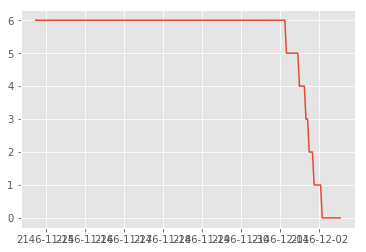

In [38]:
plot(extffn[106507]['Hydromorphone (Dilaudid)']); figure; plot(extffn[139265]['Lorazepam (Ativan)'])

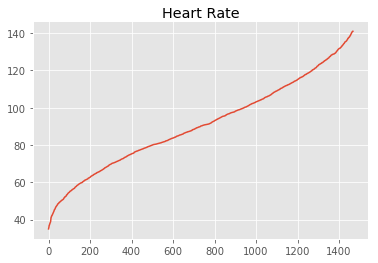

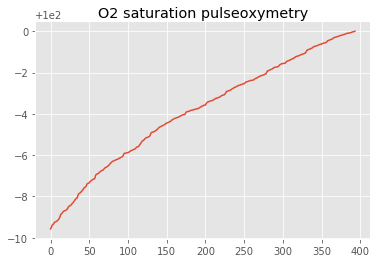

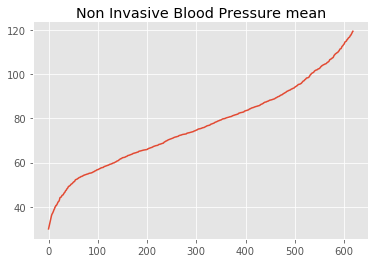

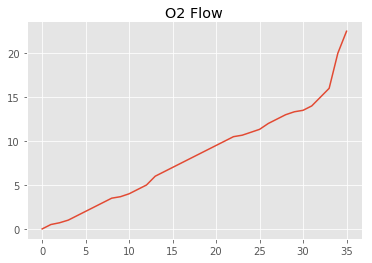

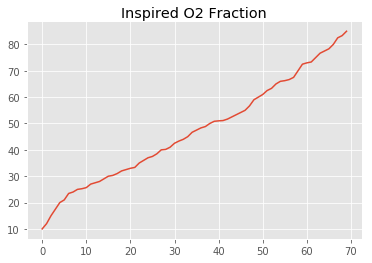

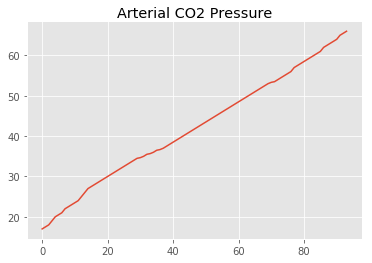

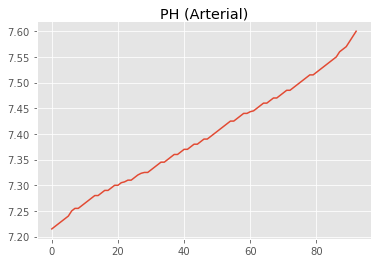

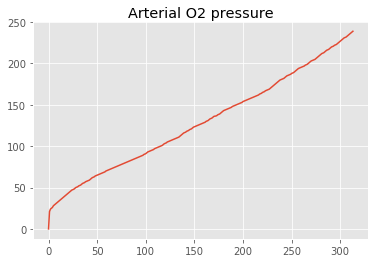

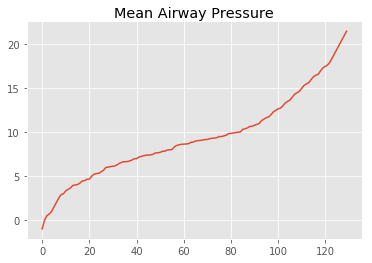

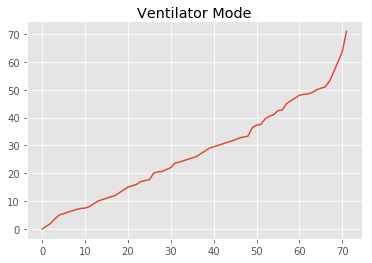

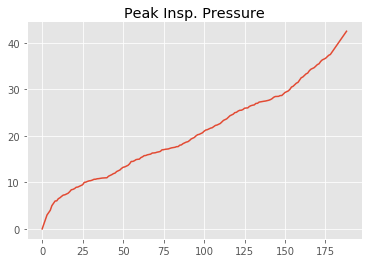

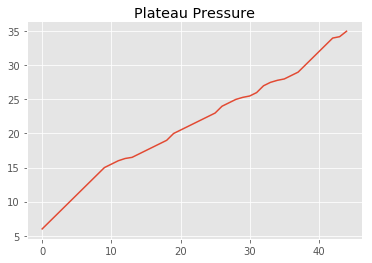

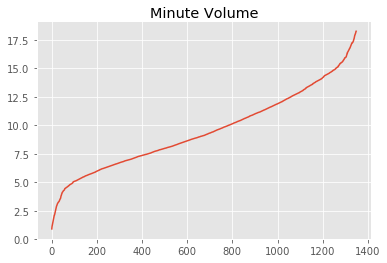

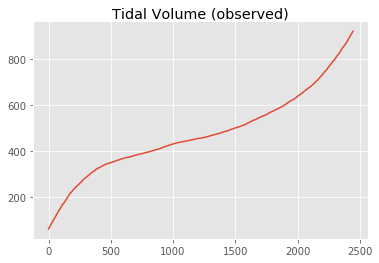

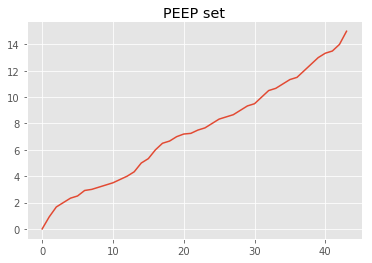

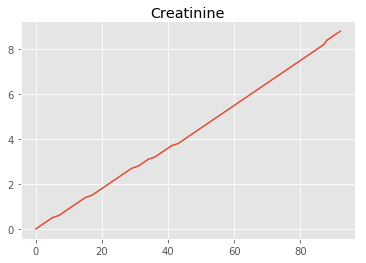

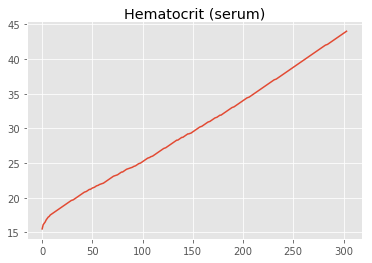

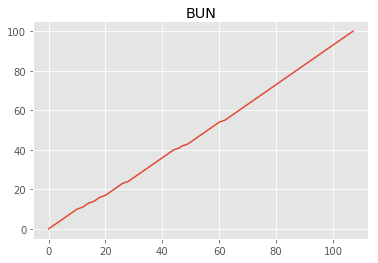

In [118]:
for v in vitals_list[:18]:
    figure()
    plot(sort(unique(np.concatenate([extffn[h][v] for h in extffn.keys()]))))
    title(v)

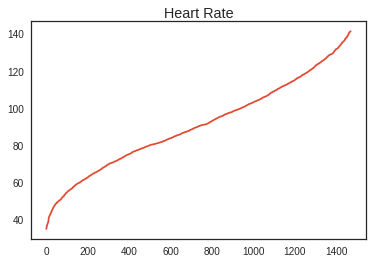

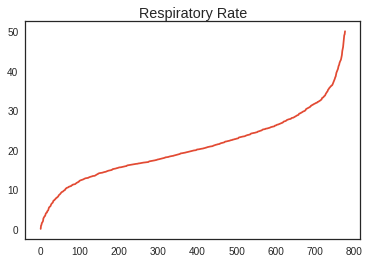

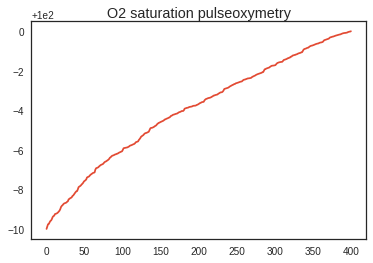

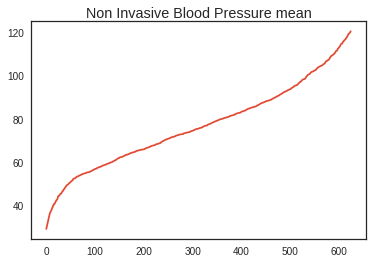

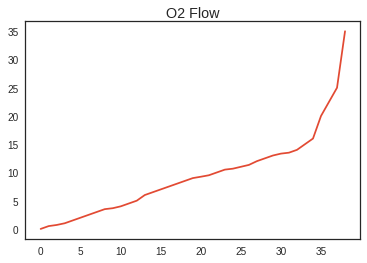

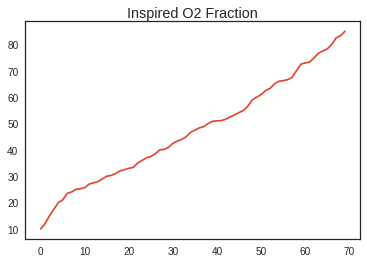

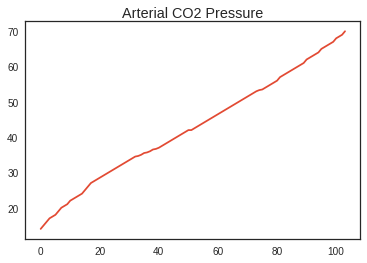

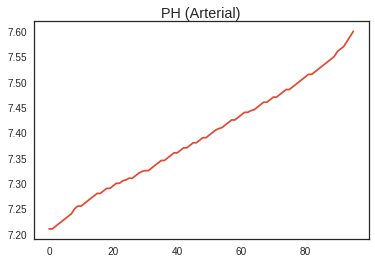

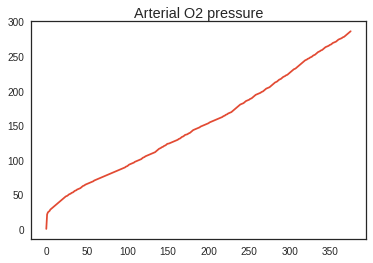

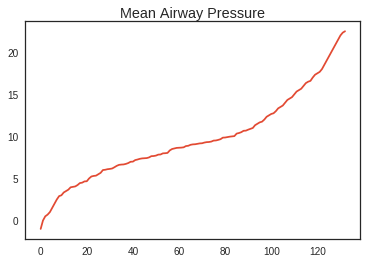

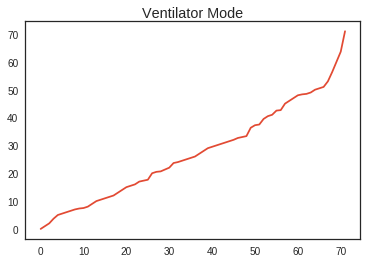

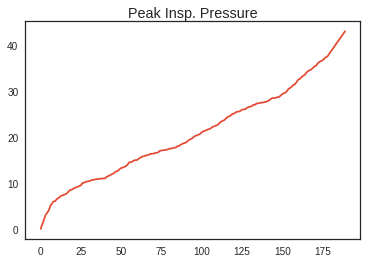

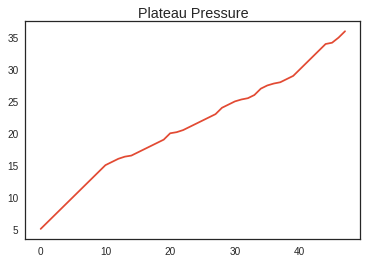

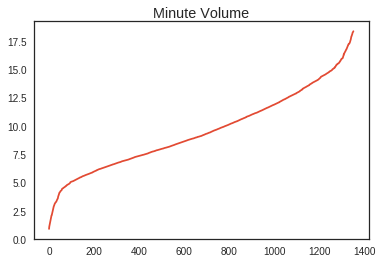

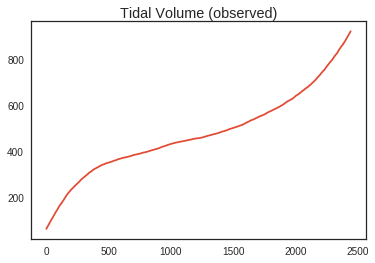

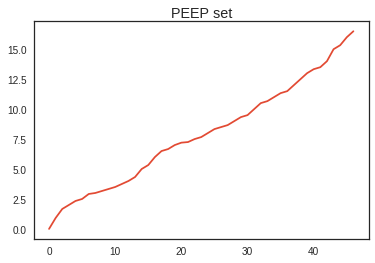

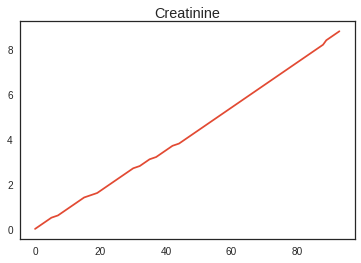

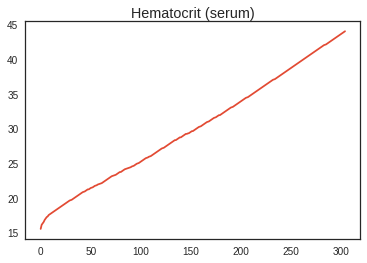

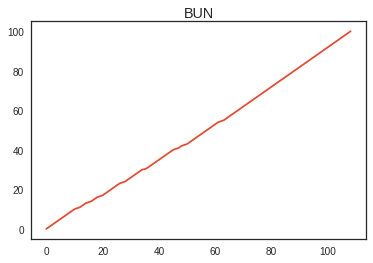

In [27]:
for v in vitals_list[:19]:
    figure()
    plot(sort(unique(np.concatenate([extffn[h][v] for h in extffn.keys()]))))
    title(v)

In [122]:
maxv={}; minv={}; meanv = {}
for v in vitals_list[:18]:
    all = np.concatenate([extffn[h][v] for h in extffn.keys()])
    print v, (nanmean(all)), nanmedian(all), (nanmean(all)-5*nanstd(all)), (nanmean(all)+5*nanstd(all))
    maxv[v] = (nanmean(all)+3*nanstd(all))
    minv[v] = (nanmean(all)-3*nanstd(all))
    meanv[v] = (nanmean(all))
    #df.ix[df.my_channel > 20000, 'my_channel'] = 0

Heart Rate 87.6098806194 87.0 -0.379977160172 175.599738399
O2 saturation pulseoxymetry 97.6984782253 98.0 86.5340590872 108.862897363
Non Invasive Blood Pressure mean 74.0252924669 72.0 2.10291642039 145.947668513
O2 Flow 8.12192643229 7.5 -18.0622450159 34.3060978805
Inspired O2 Fraction 45.6088058229 40.0 1.61177304652 89.6058385992
Arterial CO2 Pressure 41.3061114943 41.0 1.69208381217 80.9201391765
PH (Arterial) 7.41005061291 7.41 7.09266705345 7.72743417237
Arterial O2 pressure 116.695475988 110.0 -69.3562246236 302.7471766
Mean Airway Pressure 9.77565841263 9.0 -8.85931606354 28.4106328888
Ventilator Mode 26.1388592551 11.0 -71.192949003 123.470667513
Peak Insp. Pressure 19.4344631314 19.0 -19.1948325885 58.0637588514
Plateau Pressure 20.2097912903 20.0 -4.31350506972 44.7330876504
Minute Volume 9.4845870541 9.2 -3.96208866242 22.9312627706
Tidal Volume (observed) 493.262370621 488.0 -127.919078201 1114.44381944
PEEP set 6.44802661376 5.0 -7.58697448089 20.4830277084
Creatinine 

In [123]:
meanv

{'Arterial CO2 Pressure': 41.30611149434214,
 'Arterial O2 pressure': 116.69547598812647,
 'BUN': 28.651305977433335,
 'Creatinine': 1.4705628801285966,
 'Heart Rate': 87.609880619383517,
 'Hematocrit (serum)': 29.425915802080176,
 'Inspired O2 Fraction': 45.608805822869996,
 'Mean Airway Pressure': 9.7756584126322625,
 'Minute Volume': 9.4845870541036312,
 'Non Invasive Blood Pressure mean': 74.025292466916909,
 'O2 Flow': 8.1219264322859317,
 'O2 saturation pulseoxymetry': 97.698478225326468,
 'PEEP set': 6.4480266137597937,
 'PH (Arterial)': 7.4100506129118493,
 'Peak Insp. Pressure': 19.434463131441433,
 'Plateau Pressure': 20.209791290348338,
 'Tidal Volume (observed)': 493.26237062123272,
 'Ventilator Mode': 26.138859255063831}

In [32]:
with open("extffnfilledNew.pkl",'wb') as f: pickle.dump((extffn, meanv),f)

__________________________________________

In [4]:
with open("pickles/extffnfilledNew.pkl",'rb') as f: extffn, meanv = pickle.load(f)

In [142]:
extffn[extffn.keys()[4]]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan)
2141-10-28 02:00:00,2141-10-28 02:00:00,179708,54509,11,1,0,0,35,70.0,0,unknown,100.0,100.0,66.0,15.0,50.0,49.0,7.24,195.0,9.0,2.0,20.0,15.0,7.3,472.0,5.0,0.8,29.1,12.0,0,8,441,2450,0,0,1,6
2141-10-28 03:00:00,2141-10-28 03:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,100.0,100.0,66.0,15.0,40.0,49.0,7.24,195.0,9.0,2.0,20.0,15.0,7.3,472.0,5.0,0.8,29.1,12.0,0,8,3167,2450,0,0,1,6
2141-10-28 04:00:00,2141-10-28 04:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,111.0,100.0,66.0,15.0,40.0,45.0,7.24,189.0,8.0,49.0,19.0,12.0,11.1,494.0,5.0,0.8,29.1,12.0,0,8,501,2450,0,0,1,6
2141-10-28 05:00:00,2141-10-28 05:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,109.0,99.0,66.0,15.0,40.0,45.0,7.24,189.0,8.0,49.0,19.0,12.0,11.1,494.0,5.0,0.8,29.1,12.0,0,8,2241,2450,0,0,1,6
2141-10-28 06:00:00,2141-10-28 06:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,97.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,8.0,49.0,19.0,12.0,11.1,494.0,5.0,0.8,30.5,12.0,0,8,2073,2400,0,0,1,6
2141-10-28 07:00:00,2141-10-28 07:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,110.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,8.0,49.0,19.0,12.0,11.1,494.0,5.0,0.8,30.5,12.0,0,8,1083,2400,0,0,1,6
2141-10-28 08:00:00,2141-10-28 08:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,112.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,7.0,11.0,11.0,12.0,11.7,474.0,5.0,0.8,30.5,12.0,0,8,2051,2300,0,0,1,6
2141-10-28 09:00:00,2141-10-28 09:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,116.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,7.0,11.0,11.0,12.0,11.7,474.0,5.0,0.8,30.5,12.0,0,8,1836,2300,0,0,1,6
2141-10-28 10:00:00,2141-10-28 10:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,115.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,7.0,11.0,11.0,12.0,11.7,474.0,5.0,0.8,30.5,12.0,0,8,1093,2225,0,0,1,6
2141-10-28 11:00:00,2141-10-28 11:00:00,179708,54509,11,1,0,0,35,70.0,1,unknown,124.0,100.0,66.0,15.0,40.0,40.0,7.29,164.0,7.0,11.0,11.0,12.0,11.7,474.0,5.0,0.8,30.5,12.0,0,8,2695,2225,0,0,1,6


In [169]:
sum([len(extffn[extffn.keys()[i]]) for i in range(len(extffn))[:1500]])

195956

In [170]:
sum([len(extffn[extffn.keys()[i]]) for i in range(len(extffn))[1500:]])

69940

In [74]:
samples = {}; targets = {}
for h in extffn.keys():
    samples[h] = []; targets[h] = []
    for t in range(0, len(extffn[h])-1):
        vec = np.concatenate(np.array(extffn[h][['admittype','ethnicity', 'gender', 'age', 'weight']].head(1)))
        #vec = np.concatenate([vec, np.array(extffn[h][vitals_list[:18]].iloc[t-3])])
        #vec = np.concatenate([vec, np.array(extffn[h][vitals_list[:18]].iloc[t-2])])
        #vec = np.concatenate([vec, np.array(extffn[h][vitals_list[:18]].iloc[t-1])])
        vec = np.concatenate([vec, np.array(extffn[h][vitals_list[:19]].iloc[t])])
        #vec = np.concatenate([vec, np.array(extffn[h][inputs_list].iloc[t])])
        samples[h].append(vec)
        targets[h].append(extffn[h]['ventilated'].iloc[t+1])

In [75]:
with open("samplestargetsONE.pkl",'wb') as f: pickle.dump((samples, targets),f)

In [6]:
with open("pickles/samplestargetsONE.pkl",'rb') as f: (samples, targets) = pickle.load(f)

In [7]:
trainingSets = (np.concatenate([(samples[h]) for h in samples.keys()[:1500]]))
trainingSett = np.concatenate([(targets[h]) for h in targets.keys()[:1500]])
testSets = (np.concatenate([(samples[h]) for h in samples.keys()[1500:]]))
testSett = np.concatenate([(targets[h]) for h in targets.keys()[1500:]])

In [8]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
trainingSetscaled = scl.fit_transform(trainingSets)
testSetscaled = scl.transform(testSets)

In [162]:
clfb = lm.LogisticRegressionCV(class_weight='balanced')

In [163]:
clfb.fit(trainingSetscaled, trainingSett)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [128]:
sum(abs(clfb.predict(testSetscaled) - testSett)), len(testSett)

(15163, 68203)

In [173]:
len(testSetscaled)

68203

In [174]:
sum(abs(clfb.predict(testSetscaled[:68203-4]) - testSett[4:68203]))

16193

0.860065153834 0.825516237804


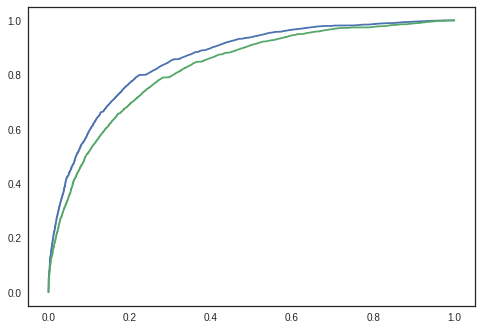

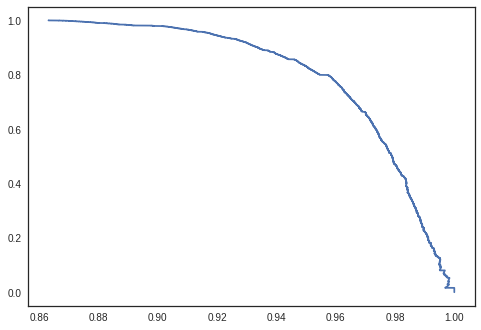

In [182]:
fpr, tpr, thresholds = roc_curve(testSett, np.transpose(clfb.predict_proba(testSetscaled))[1])
print auc(fpr,tpr),auc(fpr2,tpr2)
plot(fpr, tpr)
plot(fpr2,tpr2)
pr, re, th = precision_recall_curve(testSett, np.transpose(clfb.predict_proba(testSetscaled))[1])
figure(); plot(pr,re)

In [171]:
len(tpr)

11945

0.860065153834


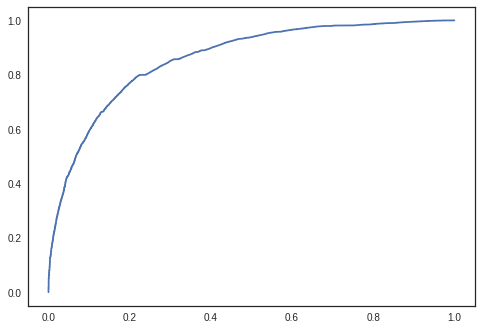

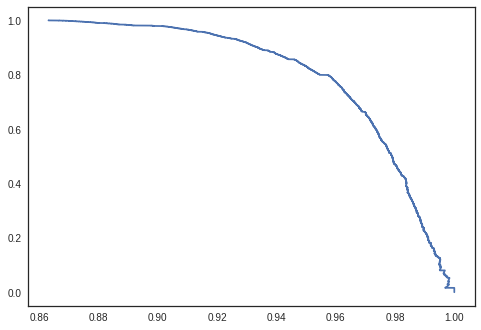

In [168]:
fpr, tpr, thresholds = roc_curve(testSett, np.transpose(clfb.predict_proba(testSetscaled))[1])
print auc(fpr,tpr)
plot(fpr, tpr)
pr, re, th = precision_recall_curve(testSett, np.transpose(clfb.predict_proba(testSetscaled))[1])
figure(); plot(pr,re)

In [293]:
sum(abs(clf.predict(testSets) - testSett))

6549

In [106]:
len(testSett), sum(testSett), len(testSett) - sum(testSett)

(69410, 60622, 8788)

In [101]:
len(clf.predict(testSets)), sum(clf.predict(testSets)), len(clf.predict(testSets)) - sum(clf.predict(testSets))

(69410, 10943, 58467)

In [105]:
len(clfb.predict(testSets)), sum(clfb.predict(testSets)), len(clfb.predict(testSets)) - sum(clfb.predict(testSets))

(69410, 25765, 43645)

In [95]:
sum(clf.predict(testSets) - testSett == 0), sum(clf.predict(testSets) - testSett < 0), sum(clf.predict(testSets) - testSett > 0)


(19189, 49950, 271)

(11190, 68203)

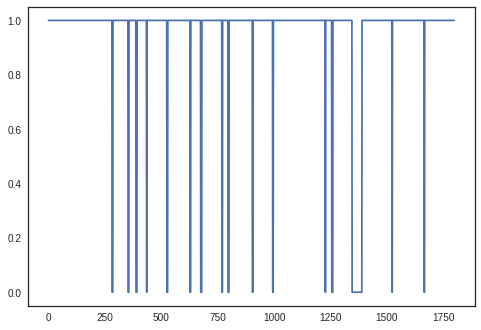

In [146]:
plot(testSett[:1800])
sum(testSett == clfb.predict(testSets)), len(testSett == clfb.predict(testSets))

In [166]:
sum(testSett), sum(clfb.predict(testSets))

(58869, 1864)

In [167]:
from sklearn.metrics import f1_score

f1_score(testSett, clfb.predict(testSets))

0.061251708296971991

In [164]:
from sklearn.metrics import confusion_matrix

confusion_matrix(testSett,clfb.predict(testSets))

array([[ 9330,     4],
       [57009,  1860]])

In [151]:
confusion_matrix(testSett,clf.predict(testSets))

array([[ 9330,     4],
       [57849,  1020]])

In [160]:
confusion_matrix(testSett,clf2.predict(testSets))

array([[ 9334,     0],
       [58749,   120]])

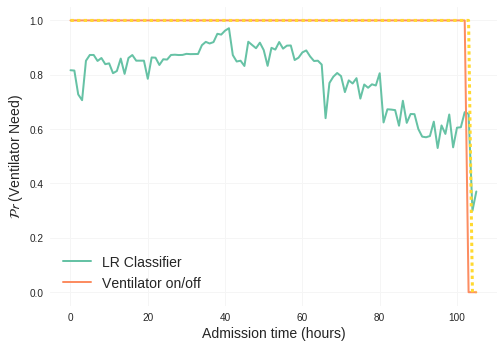

In [228]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'whitesmoke'})

i=1502
i=1509
#i=1715
#i=1800
#i=1910
#i=1947
#i=1100
plot(np.transpose(clfb.predict_proba(scl.transform(samples[samples.keys()[i]])))[1], color=sns.color_palette('Set2', 2)[0], linewidth=2)
hold(True)
plot((targets[targets.keys()[i]]), color=sns.color_palette('Set2', 2)[1], linewidth=2)
plot(np.transpose(clfb.predict(scl.transform(samples[samples.keys()[i]]))), color=sns.color_palette('Set2', 10)[5], linestyle=':', linewidth=3)

ylabel('$\mathcal{Pr } $ (Ventilator Need)', fontsize=14)
xlabel('Admission time (hours)', fontsize=14)
legend(['LR Classifier', 'Ventilator on/off'], bbox_to_anchor=(0., 0.01, 1., 2), loc=3, fontsize=14 )

In [209]:
with open("baselinecomparison.pkl",'wb') as f: pickle.dump((samples, targets, scl, clfb),f)

In [123]:
samples.keys()[1509], samples.keys()[1800]

(137131, 130101)

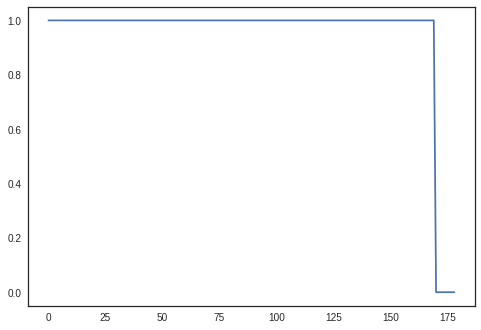

In [121]:
plot((targets[139265.0]))

In [131]:
hadms = targets.keys()

In [132]:
extffn[hadms[0]]

,timestamp,hadm,subject,icudays,admittype,ethnicity,gender,age,weight,ventilated,sbt,Heart Rate,Respiratory Rate,O2 saturation pulseoxymetry,Non Invasive Blood Pressure mean,O2 Flow,Inspired O2 Fraction,Arterial CO2 Pressure,PH (Arterial),Arterial O2 pressure,Mean Airway Pressure,Ventilator Mode,Peak Insp. Pressure,Plateau Pressure,Minute Volume,Tidal Volume (observed),PEEP set,Creatinine,Hematocrit (serum),BUN,Fentanyl (Concentrate),Midazolam (Versed),Propofol,Fentanyl,Dexmedetomidine (Precedex),Morphine Sulfate,Hydromorphone (Dilaudid),Lorazepam (Ativan)
2169-01-26 08:00:00,2169-01-26 08:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,76.000000,17.000000,100.0,66.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12
2169-01-26 09:00:00,2169-01-26 09:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,104.500000,21.500000,99.5,80.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,590,3275,0,0,0,12
2169-01-26 10:00:00,2169-01-26 10:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,90.333333,16.333333,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,9.0,49.0,26.0,20.0,8.00,491.0,5.0,0.8,38.1,6.0,0,3,1077,3275,0,0,0,12
2169-01-26 11:00:00,2169-01-26 11:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,22.000000,100.0,76.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1261,3275,0,0,0,12
2169-01-26 12:00:00,2169-01-26 12:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,88.000000,17.000000,100.0,81.0,9.241284,50.0,40.0,7.35,235.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,560,3275,0,0,0,12
2169-01-26 13:00:00,2169-01-26 13:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,102.000000,16.000000,99.0,65.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,763,3250,0,0,0,12
2169-01-26 14:00:00,2169-01-26 14:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,112.000000,16.000000,99.0,74.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,1127,3125,0,0,0,12
2169-01-26 15:00:00,2169-01-26 15:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,98.000000,16.000000,100.0,86.0,9.241284,50.0,37.0,7.35,207.0,8.0,2.0,22.0,18.0,8.00,510.0,5.0,0.8,38.1,6.0,0,3,689,3125,0,0,0,12
2169-01-26 16:00:00,2169-01-26 16:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,94.000000,16.000000,100.0,95.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,1393,3125,0,0,0,12
2169-01-26 17:00:00,2169-01-26 17:00:00,139265,47591,14,1,0,0,19,52.8,1,unknown,100.000000,15.500000,100.0,96.0,9.241284,40.0,37.0,7.35,207.0,9.0,49.0,24.0,19.0,8.50,468.0,5.0,0.8,38.1,6.0,0,3,815,3125,0,0,0,12


In [133]:
with open("baseline.pkl",'wb') as f: pickle.dump((extffn, samples, targets, scl, clf, clfb),f)

In [139]:
with open("pickles/baseline.pkl",'rb') as f: (extffnold, samplesold, targetsold, scl, clf, clfb) = pickle.load(f)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 <a list of 24 Text yticklabel objects>)

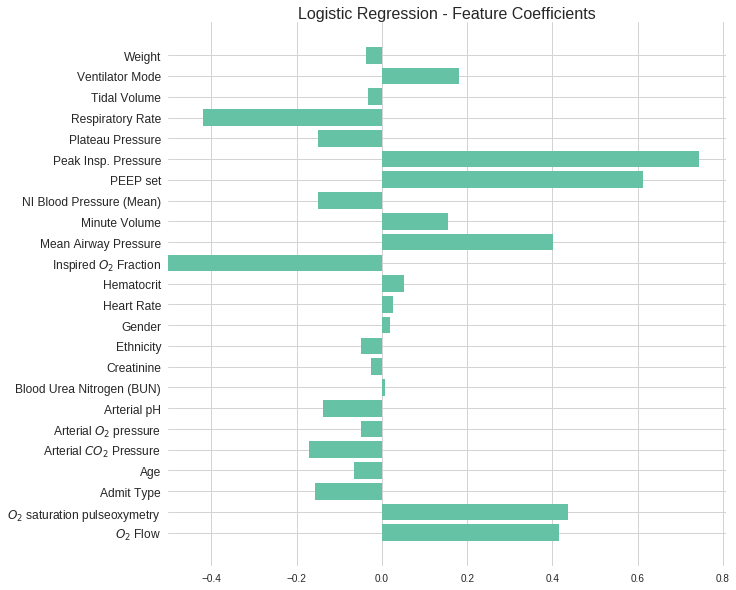

In [157]:
figure(figsize=[10,10])
feats = ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Weight', 
         'Heart Rate', 'Respiratory Rate','$O_2$ saturation pulseoxymetry', 'NI Blood Pressure (Mean)', 
        '$O_2$ Flow', 'Inspired $O_2$ Fraction', 'Arterial $CO_2$ Pressure', 'Arterial pH', 'Arterial $O_2$ pressure', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
        'Tidal Volume', 'PEEP set', 'Creatinine', 'Hematocrit', 'Blood Urea Nitrogen (BUN)']
#sns.barplot(np.concatenate(clfb.coef_), feats, orient='h', palette=sns.color_palette('Set2', 24))
barh(feats, np.concatenate(clfb.coef_), color=sns.color_palette('Set2')[0])
title('Logistic Regression - Feature Coefficients', fontsize=16)
yticks(fontsize=12)

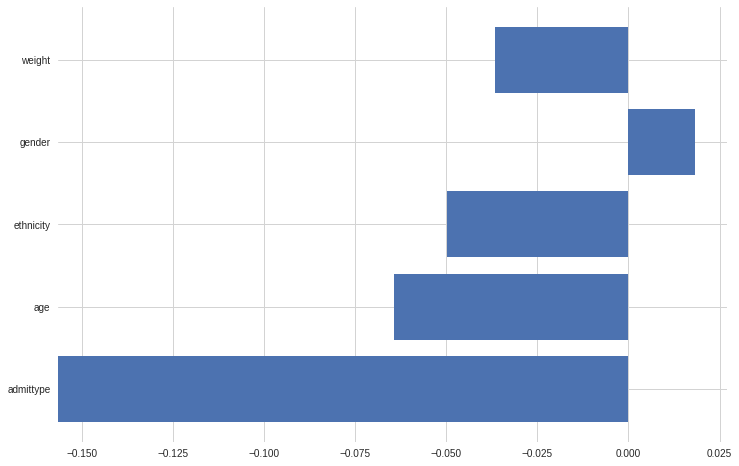

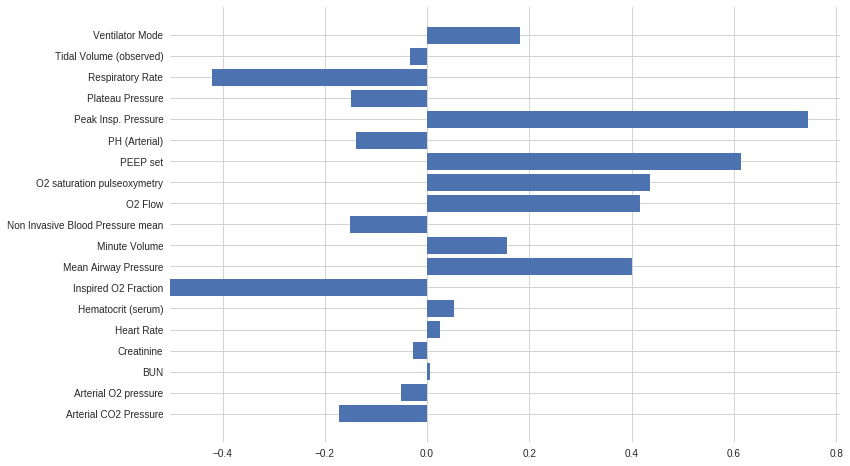

In [140]:
figsize(12,8)
barh(['admittype','ethnicity', 'gender', 'age', 'weight'], np.concatenate(clfb.coef_)[:5]); figure()
barh(vitals_list[:19], np.concatenate(clfb.coef_)[5:24]) ; figure()

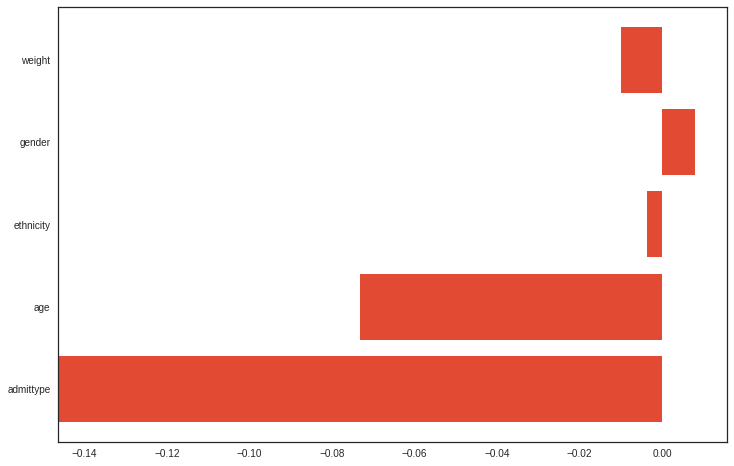

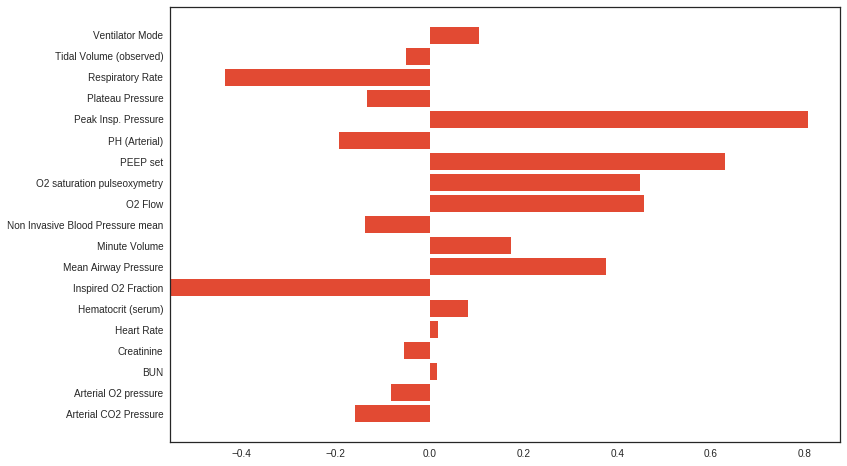

In [115]:
figsize(12,8)
barh(['admittype','ethnicity', 'gender', 'age', 'weight'], np.concatenate(clf.coef_)[:5]); figure()
barh(vitals_list[:19], np.concatenate(clf.coef_)[5:24]) ; figure()

<Container object of 8 artists>

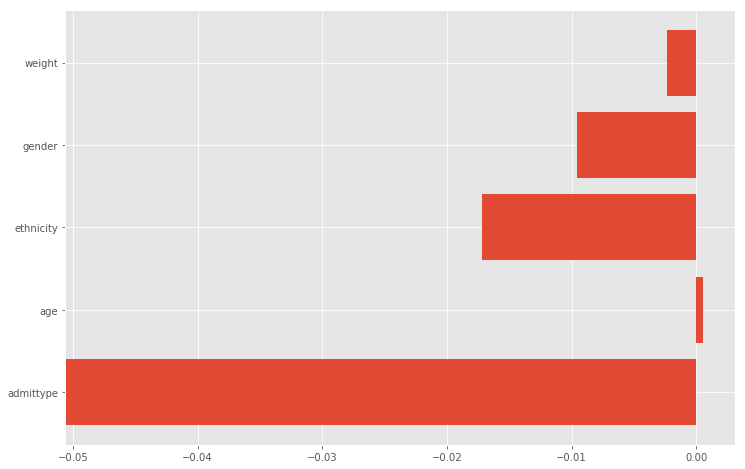

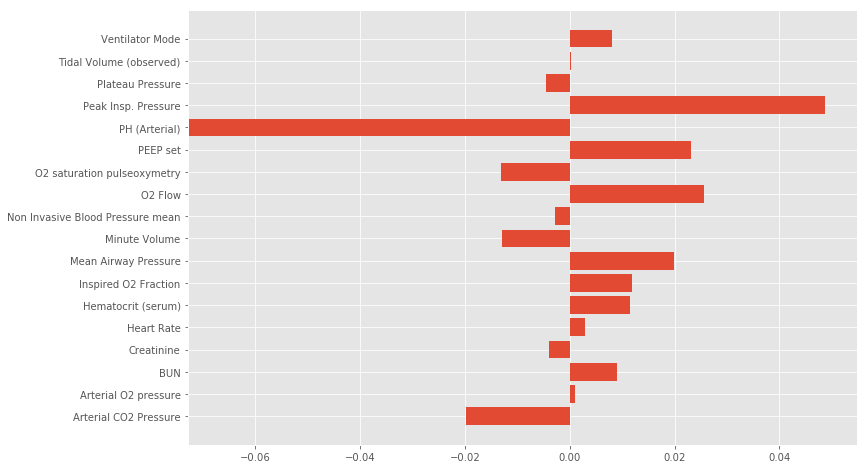

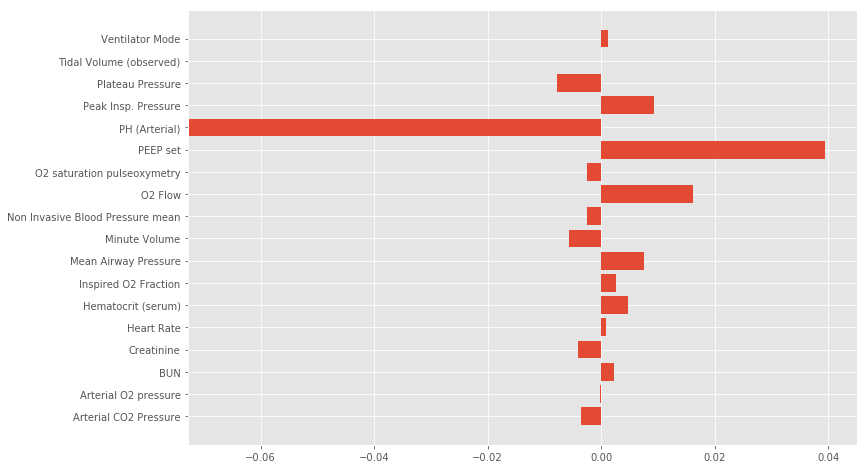

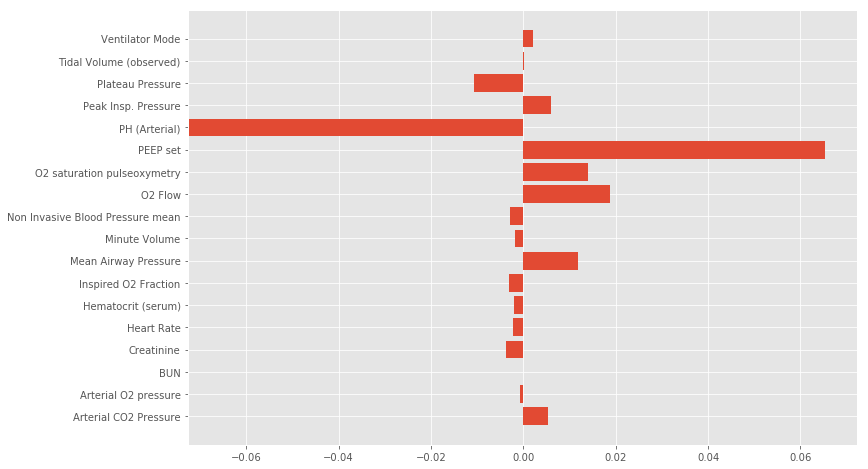

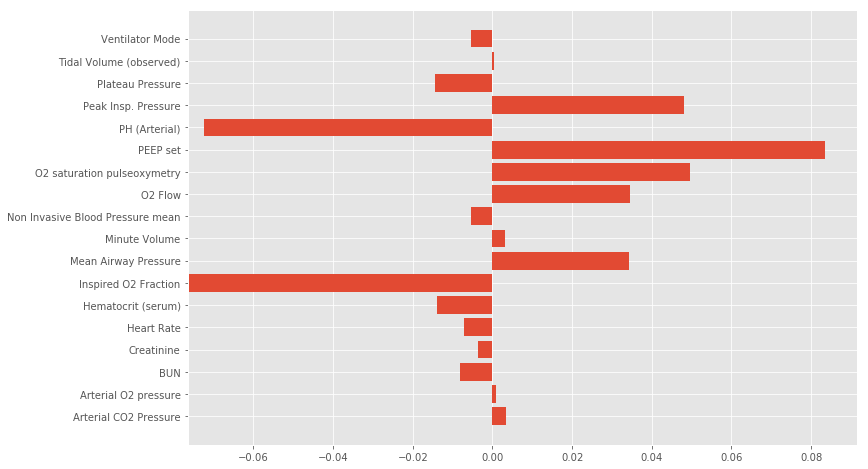

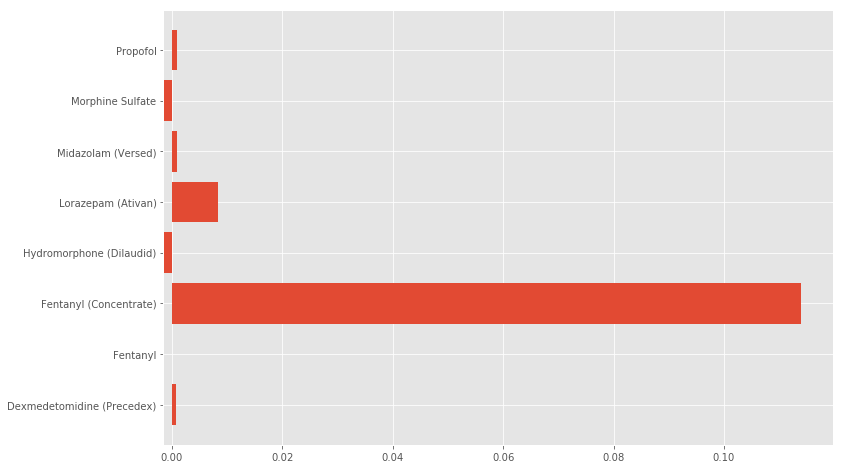

In [129]:
figsize(12,8)
barh(['admittype','ethnicity', 'gender', 'age', 'weight'], np.concatenate(clf.coef_)[:5]); figure()
barh(vitals_list[:18], np.concatenate(clf.coef_)[5:23]) ; figure()
barh(vitals_list[:18], np.concatenate(clf.coef_)[23:41]); figure()
barh(vitals_list[:18], np.concatenate(clf.coef_)[41:59]); figure()
barh(vitals_list[:18], np.concatenate(clf.coef_)[59:77]); figure()
barh(inputs_list, np.concatenate(clf.coef_)[77:])

In [58]:
vitd_lenfiltered = pd.read_pickle("vitd_lenfiltered.pkl")

In [61]:
unique(vitd_lenfiltered.label)

array(['Heart Rate', 'O2 saturation pulseoxymetry',
       'Non Invasive Blood Pressure mean', 'O2 Flow',
       'Inspired O2 Fraction', 'Creatinine', 'Hematocrit (serum)', 'BUN',
       'Arterial CO2 Pressure', 'PH (Arterial)', 'Arterial O2 pressure',
       'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure',
       'Plateau Pressure', 'Minute Volume', 'Tidal Volume (observed)',
       'PEEP set', 'Admission Weight (Kg)'], dtype=object)

In [ ]:
with open("samplestargetsONE.pkl",'wb') as f: pickle.dump((samples, targets),f)

In [ ]:
def setTimeIntnum(frame):
    frame.index = range(len(frame))
    frame['duration'] = np.zeros(len(frame.index))
    frame['intubations'] = 0
    span = 0
    for t in frame.index:
        if frame.ventilated[t] == 1: span += 1
        else: span = 0
        frame.loc[t, 'duration'] = span
        if frame.ventilated[t] == 1:
            if t == 0: 
                frame.loc[t, 'intubations'] = 1
            elif frame.ventilated[t-1] == 1:
                frame.loc[t, 'intubations'] = frame.intubations[t-1]
            elif frame.ventilated[t-1] == 0:
                frame.loc[t, 'intubations'] = frame.intubations[t-1] + 1
        elif t != 0:
            frame.loc[t, 'intubations'] = frame.intubations[t-1]
    return frame  

for h in extffn.keys():
    setTimeIntnum(extffn[h])

In [285]:
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';', 
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']
stopWords = stopwords.words("english")

words = {}
pts = []
for d in np.array(vent_filtered.diagnosis):
    raw = re.sub('[%s]' % ''.join(chars), ' ', d)    
    tokens = word_tokenize(raw)
    tokens = [w for w in tokens if len(w) >= 2]
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [w for w in tokens if w not in ['sda']]
    for t in tokens: 
        try:
            words[t] = words[t]+1
        except:
            words[t] = 1
    pts.append(tokens)
    
words_sorted = sorted(words, key=words.get, reverse=True)
for r in words_sorted:
    print r, words[r]
    
from gensim import corpora, models

dictionary = corpora.Dictionary(pts)
corpus = [dictionary.doc2bow(pt) for pt in pts]

ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary, passes=50)
ldamodel.print_topics(num_topics=100, num_words=10)

txt2 = ' . '.join([' '.join(pts[i]) for i in range(len(pts))])
txt = ' '.join(np.concatenate(pts))

from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color="white", width=800, height=600, collocations=True, max_font_size=80, max_words=150)
# generate word cloud
wc.generate(txt2)
figsize(16,12)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [55]:
def drawChartFrame(h, ventTable, sedTable, vitTable, sbtTable, vitalsList, sedationList, sbtList): 
    
    # "Tableau 20" colors as RGB.   
    tableau20 = [(31, 119, 180), (174, 199, 232), (247, 182, 210), (255, 187, 120),    
                 (44, 160, 44), (140, 86, 75), (255, 152, 150),  (214, 39, 40),  
                 (148, 103, 189), (197, 176, 213), (152, 223, 138), (196, 156, 148),    
                 (227, 119, 194), (255, 127, 14), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
    tableau20 = [(227, 119, 194), (148, 103, 189), (255, 127, 14), (44, 160, 44),    
                 (31, 119, 180), (140, 86, 75),  (214, 39, 40), (255, 152, 150),  
                 (174, 199, 232), (197, 176, 213), (152, 223, 138), (196, 156, 148),    
                 (255, 187, 120), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)
    
    #tableau20 = sns.color_palette('Accent',20)

    fig = plt.figure(figsize=(22, 14))
    plt.rcParams.update({'font.size': 22})
    
    admitTime =  pd.to_datetime(ventTable[ventTable.hadm == h].admit_time.unique().item())
    admitTime -= dt.timedelta(minutes=admitTime.minute, seconds=admitTime.second, microseconds=
                              admitTime.microsecond)    
    dischTime = pd.to_datetime(ventTable[ventTable.hadm == h].discharge_time.unique().item())
    dischTime -= dt.timedelta(minutes=dischTime.minute, seconds=dischTime.second, microseconds=
                              dischTime.microsecond)
    dischTime += dt.timedelta(hours = 1)
    
    iter = 0
    for i,row in ventTable[ventTable.hadm == h].iterrows():
        ventStart = pd.to_datetime(row.vent_starttime)
        ventStart -= dt.timedelta(minutes=ventStart.minute, seconds=ventStart.second, microseconds=
                                  ventStart.microsecond)
        ventStart += dt.timedelta(hours = 1)
        ventEnd = pd.to_datetime(row.vent_endtime)
        ventEnd -= dt.timedelta(minutes=ventEnd.minute, seconds=ventEnd.second, microseconds=ventEnd.microsecond)
        
        plt.plot([ventStart,ventEnd],[180]*2,color=tableau20[16], lw=2)
        if (iter==0): plt.text(ventStart,182,"Ventilation",fontsize=15)  
        iter += 1        
    
    iter = 0
    for i,row in sbtTable[sbtTable.hadm == h].iterrows():
        sbtEventname = row.label
        sbtEventtime = pd.to_datetime(row.charttime)
        plt.plot([sbtEventtime],[180],color=tableau20[16], marker=r'$|$', markersize=20, lw=2)
        plt.text(sbtEventtime,182+5*iter,sbtEventname,fontsize=15)  
        iter += 1  
        
    iter = 1
    for v in vitalsList:
        vitals_v = vitTable[(vitTable.hadm == h) & (vitTable.label == v)].sort_values(by='charttime')
        vitals_v.set_index('charttime',inplace=True,drop=False)
        #vitals_v = vitals_v.resample('1h').mean().fillna(method="ffill")    
        vitals_v['timestamp'] = vitals_v.index
        plot(vitals_v.timestamp, vitals_v.value, color=tableau20[iter], lw=1.5, marker='.', label = v)
        iter += 1

    iter = 0
    for s in sedationList:
        iter += 1
        j = 1
        for i,row in sedTable[(sedTable.hadm==h) & (sedTable.label==s)].iterrows():
            if not row.empty:
                sedStart = pd.to_datetime(row.input_start)
                sedEnd = pd.to_datetime(row.input_end)
                plt.plot([sedStart,sedEnd],[120+10*iter]*2,color=tableau20[18], marker=r'$|$', markersize=12, lw=2)
                amt = str(round(row.amount)) + row.amountuom
                if (j==1): plt.text(sedStart,122+10*iter,s,fontsize=15)
                #else: plt.text(sedStart,122+10*iter,amt,fontsize=8)
                j += 1
    
                    
    plt.legend(bbox_to_anchor=(0.88, 0.6),loc=8,fontsize=16,frameon=True,shadow=True)
    plt.xlabel('Admission Timestamp', fontsize=22)
    plt.ylabel('Measurement value', fontsize=22)
    plt.yticks(np.arange(0, 210, 10), fontsize=16)
    plt.xticks(fontsize=16)

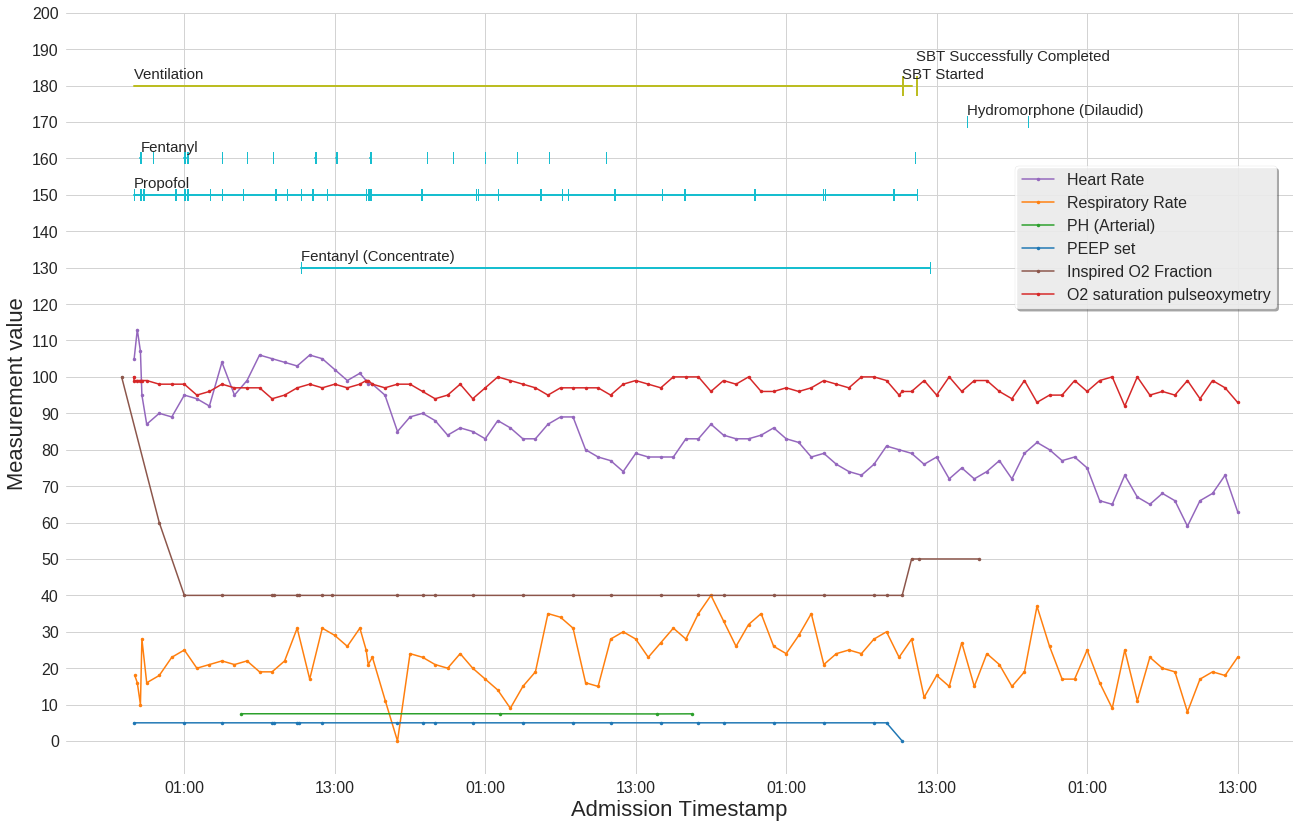

In [56]:
#h = 104140|165660|115545|19269
h = 174021 # pretty good
#h = 165660
#h = 184860 #good
#h = 188432
#h = 139265 #good
#h = 191148
plt.style.use('seaborn-white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})
drawVits = ['Heart Rate', 'Respiratory Rate','PH (Arterial)','PEEP set','Inspired O2 Fraction', 
            'O2 saturation pulseoxymetry']
#           'Non Invasive Blood Pressure mean','Mean Airway Pressure','Ventilator Mode','Tidal Volume (observed)',
#           'Richmond-RAS Scale','Arterial O2 pressure','Arterial CO2 Pressure'

seds_list = ['Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Hydromorphone (Dilaudid)',
             'Dexmedetomidine (Precedex)','Morphine Sulfate', 'Lorazepam (Ativan)']

sbt_list = ['SBT Started', 'SBT Stopped', 'SBT Successfully Completed', 'SBT Deferred']

drawChartFrame(h, vent_discharged, inputs_discharged, allvitals_discharged, sbt_discharged, drawVits, seds_list, sbt_list)


In [57]:
len(vent_discharged.hadm.unique())

7339

In [59]:
with open("pickles/baseFrames.pkl",'rb') as f: (extffn, sclv) = pickle.load(f)

In [60]:
len(extffn)

2030

In [61]:
all = [extffn[h] for h in extffn.keys()]

In [66]:
all2 = pd.concat(all)

In [73]:
mean(all2[all2.ventilated == 1]['Heart Rate']), mean(all2[all2.ventilated == 0]['Heart Rate'])

(87.160045823955244, 90.802571147609029)

In [76]:
mean(all2[all2.ventilated == 1]['Respiratory Rate']), mean(all2[all2.ventilated == 0]['Respiratory Rate'])

(19.447586711554766, 21.836994839510922)

In [74]:
mean(all2[all2.ventilated == 1]['PH (Arterial)']), mean(all2[all2.ventilated == 0]['PH (Arterial)'])

(7.4074723744822828, 7.4233557895895057)

In [77]:
mean(all2[all2.ventilated == 1]['PEEP set']), mean(all2[all2.ventilated == 0]['PEEP set'])

(6.8827817468887389, 4.652241165662522)

In [78]:
mean(all2[all2.ventilated == 1]['Arterial CO2 Pressure']), mean(all2[all2.ventilated == 0]['Arterial CO2 Pressure'])

(41.749572000466451, 41.698690526446399)

(Text(0.5,0,u'Hours'), Text(0,0.5,u'Density'))

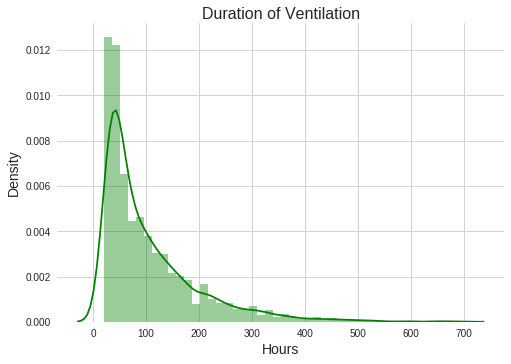

In [122]:
sns.distplot([max(extffn[h]['duration']) for h in extffn.keys()], color='g')
title('Duration of Ventilation', fontsize=16)
xlabel('Hours', fontsize=14), ylabel('Density', fontsize=14)

In [101]:
tmp = []
for i in inputs_list:
    tmp.append(len(all2[all2[i] != 0]))

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text yticklabel objects>)

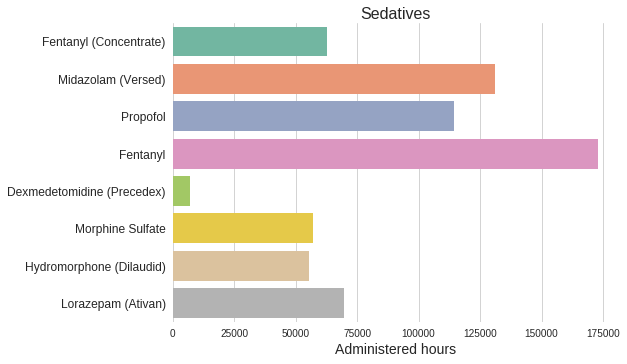

In [138]:
sns.barplot( tmp, inputs_list, orient='h', palette=sns.color_palette('Set2', 8))
xlabel('Administered hours',fontsize=14), title('Sedatives', fontsize=16)
yticks(fontsize=12)